## Categorizing Data: GJ Weather Data

## 1) Create a temperature category Target

In [2]:
%pip install --quiet pandas numpy scikit-learn matplotlib requests pytz


import pandas as pd
import requests
from datetime import date

# Grand Junction, CO
LAT, LON = 39.0639, -108.5506

START = "2019-01-01"
END = date.today().isoformat()

DAILY_VARS = [
    "temperature_2m_max", "temperature_2m_min",
    "precipitation_sum", "rain_sum", "snowfall_sum",
    "windspeed_10m_max", "windgusts_10m_max",
    "shortwave_radiation_sum", "et0_fao_evapotranspiration",
    "sunshine_duration", "daylight_duration"
]

params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": START,
    "end_date": END,
    "daily": ",".join(DAILY_VARS),
    "timezone": "America/Denver"
}

url = "https://archive-api.open-meteo.com/v1/archive"
response = requests.get(url, params=params)
response.raise_for_status()
raw = response.json()

df = pd.DataFrame(raw["daily"])
df["time"] = pd.to_datetime(df["time"])
df = df.set_index("time").sort_index()

# Cleanup column names
df.columns = [c.replace("_2m","").replace("_10m","") for c in df.columns]



### Categories
data = df.copy()

# Calendar features
data["doy"] = data.index.dayofyear
data["month"] = data.index.month

# Create temperature class
data["temp_class"] = pd.cut(
    data["temperature_max"],
    bins=[-50, 5, 20, 60],   # °C thresholds — adjust later if you want!
    labels=["Cold", "Mild", "Hot"]
)

# Remove missing class data
data = data.dropna(subset=["temp_class"])

data.head(), data["temp_class"].value_counts()


data = df.copy()

# Calendar features
data["doy"] = data.index.dayofyear
data["month"] = data.index.month

# Create temperature class
data["temp_class"] = pd.cut(
    data["temperature_max"],
    bins=[-50, 5, 20, 60],   # °C thresholds — adjust later if you want!
    labels=["Cold", "Mild", "Hot"]
)

# Remove missing class data
data = data.dropna(subset=["temp_class"])

data.head(), data["temp_class"].value_counts()







[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


(            temperature_max  temperature_min  precipitation_sum  rain_sum  \
 time                                                                        
 2019-01-01             -6.6            -13.0                1.1       0.0   
 2019-01-02             -3.8            -16.1                0.0       0.0   
 2019-01-03             -1.1            -13.3                0.0       0.0   
 2019-01-04              1.0             -8.6                0.0       0.0   
 2019-01-05              1.4             -8.7                0.0       0.0   
 
             snowfall_sum  windspeed_max  windgusts_max  \
 time                                                     
 2019-01-01          0.77            7.6           18.4   
 2019-01-02          0.00            8.4           15.8   
 2019-01-03          0.00            9.7           21.6   
 2019-01-04          0.00            6.1           19.4   
 2019-01-05          0.00            8.6           24.8   
 
             shortwave_radiation_sum 

## 2) Define X (features) and y (labels) + Train/Test Split

In [3]:
from sklearn.model_selection import train_test_split

# Features: everything except the target
feature_cols = [
    "temperature_min", "precipitation_sum", "rain_sum", "snowfall_sum",
    "windspeed_max", "windgusts_max",
    "shortwave_radiation_sum", "et0_fao_evapotranspiration",
    "sunshine_duration", "daylight_duration",
    "doy", "month"
]
# Keep only those present in dataset
feature_cols = [c for c in feature_cols if c in data.columns]

X = data[feature_cols]
y = data["temp_class"]

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((1994, 12), (499, 12))

## 3) KNN Classification


✅ KNN Accuracy: 0.886

Classification Report:
               precision    recall  f1-score   support

        Cold       0.80      0.73      0.76        62
         Hot       0.93      0.96      0.94       258
        Mild       0.85      0.83      0.84       179

    accuracy                           0.89       499
   macro avg       0.86      0.84      0.85       499
weighted avg       0.88      0.89      0.88       499



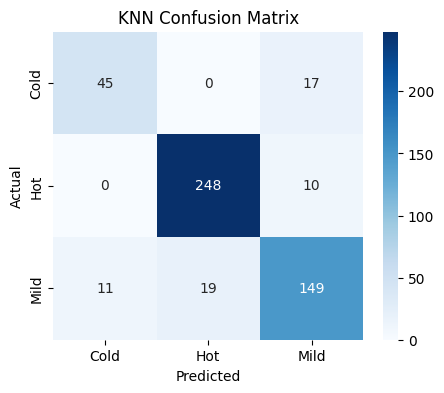

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# KNN with scaling pipeline
knn_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

# Evaluation
knn_accuracy = accuracy_score(y_test, knn_pred)
print("✅ KNN Accuracy:", round(knn_accuracy, 3))
print("\nClassification Report:\n", classification_report(y_test, knn_pred))

# Confusion matrix heatmap
cm_knn = confusion_matrix(y_test, knn_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=knn_model.classes_,
            yticklabels=knn_model.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 7) Decision Tree Classifier

✅ Decision Tree Accuracy: 0.934

Classification Report:
               precision    recall  f1-score   support

        Cold       0.96      0.76      0.85        62
         Hot       0.97      0.97      0.97       258
        Mild       0.88      0.95      0.91       179

    accuracy                           0.93       499
   macro avg       0.94      0.89      0.91       499
weighted avg       0.94      0.93      0.93       499



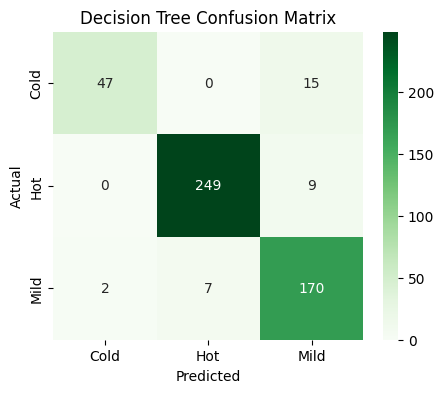

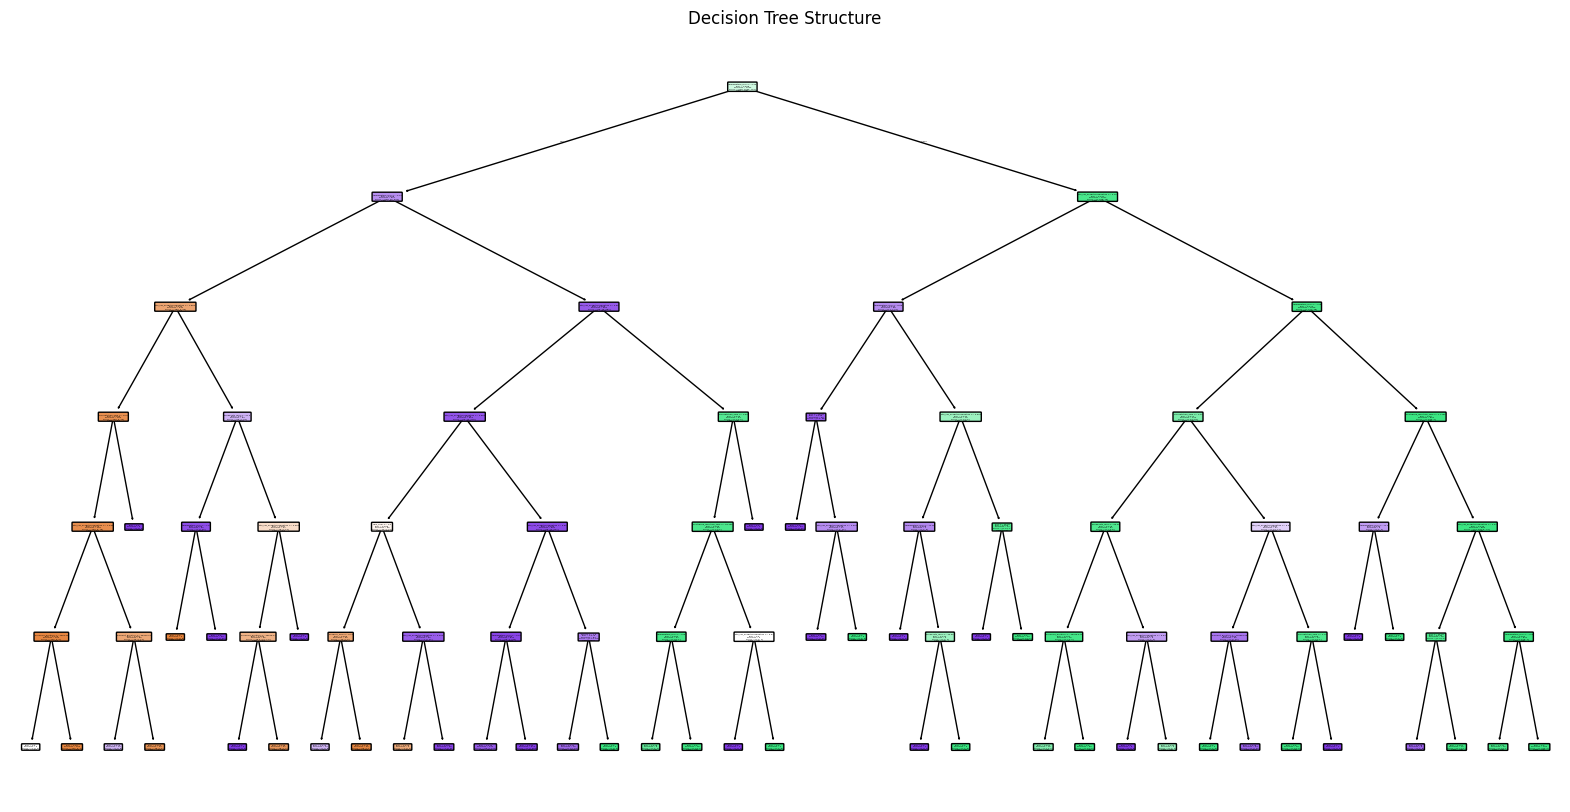

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

dt_model = DecisionTreeClassifier(
    max_depth=6,   # helps prevent overfitting
    random_state=42
)

dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)
print("✅ Decision Tree Accuracy:", round(dt_accuracy, 3))
print("\nClassification Report:\n", classification_report(y_test, dt_pred))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens",
            xticklabels=dt_model.classes_,
            yticklabels=dt_model.classes_)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Optional: Visualize Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(dt_model,
               feature_names=X_train.columns,
               class_names=dt_model.classes_,
               filled=True,
               rounded=True)
plt.title("Decision Tree Structure")
plt.show()


## 8) Compare Model Accuracies

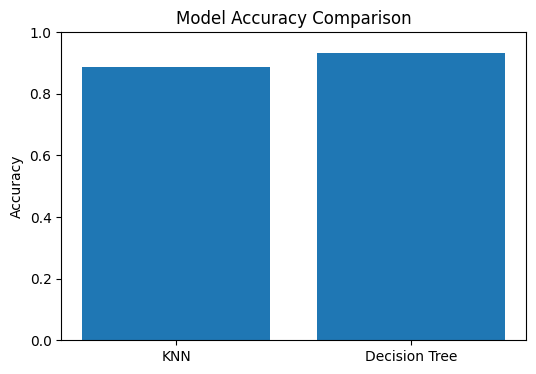

{'KNN': 0.8857715430861723, 'Decision Tree': 0.9338677354709419}

In [11]:
import matplotlib.pyplot as plt

accuracies = {
    "KNN": knn_accuracy,
    "Decision Tree": dt_accuracy
}

plt.figure(figsize=(6,4))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

accuracies
